In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
ROOT = '.data'

train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True)

In [3]:
BIT_DEPTH = 8
MAX_VALUE = pow(2, BIT_DEPTH) - 1

mean = train_data.data.float().mean() / MAX_VALUE
std = train_data.data.float().std() / MAX_VALUE

In [4]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [5]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [std])
                                     ])

In [6]:
train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

test_data = datasets.MNIST(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = test_transforms)

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [8]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.axis('off')

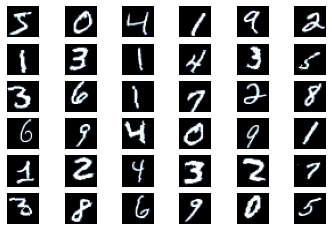

In [9]:
N_IMAGES = 36

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]] 

plot_images(images)

In [10]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [11]:
train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [12]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


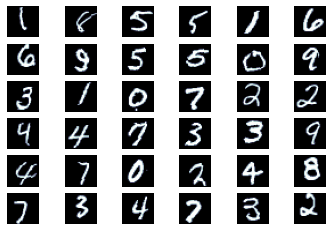

In [13]:

N_IMAGES = 36

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]] 

plot_images(images)

In [14]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

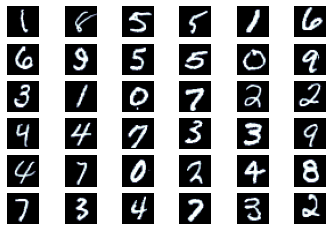

In [15]:
N_IMAGES = 36

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]] 

plot_images(images)

In [16]:
BATCH_SIZE = 1024

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [17]:
H_1_DIM = 250
H_2_DIM = 100
# H_3_DIM = 50

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, H_1_DIM)
        self.hidden_fc_1 = nn.Linear(H_1_DIM, H_2_DIM)
        # self.hidden_fc_2 = nn.Linear(H_2_DIM, H_3_DIM)
        self.output_fc = nn.Linear(H_2_DIM, output_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc_1(h_1))
        # h_3 = F.relu(self.hidden_fc_2(h_2))
        y_pred = self.output_fc(h_2)

        return y_pred, h_2

In [18]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 222,360 trainable parameters


In [21]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [22]:
def train(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    # start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    # end_time = time.monotonic()

    # epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    # print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'{epoch+1},{train_loss},{train_acc},{valid_loss},{valid_acc}')

1,1.0069545619892624,0.6946911215782166,0.3897869537274043,0.8853012522061666
2,0.4346948631529538,0.8706793672633621,0.24233180284500122,0.9348159233729044
3,0.2818294606118832,0.9176958923069936,0.1722937449812889,0.9515684147675832
4,0.21624821986792223,0.935923621339618,0.14194718996683756,0.9594371418158213
5,0.18107545122785387,0.9466254295043226,0.1241402377684911,0.9638819793860117
6,0.15874931834778697,0.952330341878927,0.11072003468871117,0.9681403835614523
7,0.14054086087447293,0.9573927071859252,0.10318142424027126,0.9700935085614523
8,0.1311869946009708,0.9605717299119482,0.09238969534635544,0.9719371398289999
9,0.12200578878510673,0.9629353161128062,0.08483124896883965,0.9725881814956665
10,0.11288015221087437,0.9657760116289247,0.07898887619376183,0.9734286169211069


In [26]:
model.load_state_dict(torch.load('model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

# print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
print(f'{test_loss},{test_acc}')

0.07249887846410275,0.9749960124492645
